<a href="https://colab.research.google.com/github/OVP2023/NN/blob/main/%D0%9D%D0%9D_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%B8_%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D1%81%D0%BB%D0%BE%D0%B8_%D0%BE%D0%B1%D0%B5%D1%80%D1%82%D0%BA%D0%B0_%D0%B2_%D0%BA%D0%BB%D0%B0%D1%81%D1%81__%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BE%D0%B2_%D0%B22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import cv2
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.18.0


In [21]:
PLATE_NUM_LENGTH = 8

TEST_DATA_PATH = '/content/drive/MyDrive/Datasets/CV/plate/test'
TRAIN_DATA_PATH = '/content/drive/MyDrive/Datasets/CV/plate/train'

IMG_WIDTH = 128
IMG_HEIGHT = 64

POOL_NUM = 2
DOWNSAMPLE = POOL_NUM ** 2

In [22]:
#Загружаем алфавит
import os
import json
from collections import Counter
from glob import glob


def load_char_counts(path):
    """Загружаем словарь символов на основе данных разметки"""
    counts = Counter()
    for filename in glob(os.path.join(path, 'ann', '*.json')):
        with open(filename, 'r') as src:
            annotation = json.load(src)
        label = annotation['description']
        assert len(label) == PLATE_NUM_LENGTH
        counts.update(label)
    return counts

LETTERS = sorted(load_char_counts(TRAIN_DATA_PATH).keys())
print('Letters:', ' '.join(LETTERS))

Letters: 0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


In [23]:
#Утилиты подготовки входных данных

import random
import functools

def indices_to_text(indicies, letters):
    """Возвращает текст для заданных индексов"""
    return ''.join(map(letters.__getitem__, indicies))

def text_to_indices(text, letters):
    """Конвертирует текст в список индексов"""
    return list(map(letters.index, text))

class DataGenerator:
    """Загрузка и подготвка данных для обучения/тестирования"""
    def __init__(self,
                 path,
                 img_width,
                 img_height,
                 batch_size,
                 letters,
                 max_label_len):

        self._img_height = img_height
        self._img_width = img_width
        self._batch_size = batch_size
        self._letters = letters
        self._max_label_len = max_label_len

        self._files = []
        for img_path in glob(os.path.join(path, 'img', '*.png')):
            basename, _ = os.path.splitext(os.path.basename(img_path))
            annotation_path = os.path.join(path, 'ann', '%s.json' % basename)
            with open(annotation_path, 'r') as src:
                annotation = json.load(src)
                self._files.append((img_path, annotation['description']))

    @property
    def steps_per_epoch(self):
        return len(self._files) // self._batch_size

    @functools.lru_cache(maxsize=1024)
    def _load_img(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self._img_width, self._img_height))
        img = np.float32(img) / 255.
        return img.reshape((self._img_height, self._img_width, 1))

    def __call__(self):
        while True:
            assert self.steps_per_epoch > 0

            batch_img = np.zeros(
                [self._batch_size,
                 self._img_height, self._img_width, 1], np.float32)

            random.shuffle(self._files)
            for i in range(0, len(self._files), self._batch_size):
                k = i + self._batch_size
                if k > len(self._files):
                    break

                batch_labels = np.zeros([self._batch_size,
                                         self._max_label_len], np.int32)

                batch_labels_length = np.zeros([self._batch_size, 1])

                for j, (img_path, label) in enumerate(self._files[i:k]):
                    batch_img[j] = self._load_img(img_path)
                    batch_labels[j] = text_to_indices(label, self._letters)
                    batch_labels_length[j] = len(label)

                outputs = {
                    'labels': batch_labels,
                    'labels_length': batch_labels_length
                }

                yield batch_img, outputs



Text generator output (data which will be fed into the neutral network):
1) input (image) 64x128


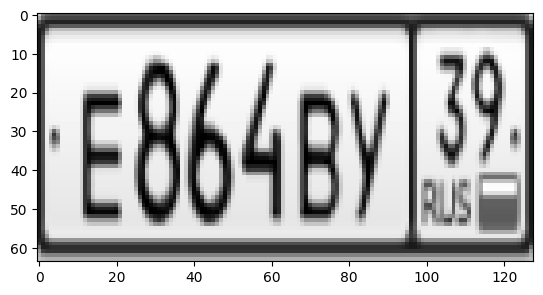

2) labels (plate number): E864BY39 is encoded as [13  8  6  4 11 21  3  9]
3) label_length (length of plate number): 8


<ipython-input-24-5475fe06d8ca>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('3) label_length (length of plate number): %d' % label_length)


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

data = DataGenerator(TRAIN_DATA_PATH,
                     batch_size=1,
                     img_width=128,
                     img_height=64,
                     letters=LETTERS,
                     max_label_len=PLATE_NUM_LENGTH)

x, y_true = next(data())
label_indices = y_true['labels'][0]
label = indices_to_text(label_indices, LETTERS)
label_length = y_true['labels_length'][0]

print('Text generator output (data which will be fed into the neutral network):')
print('1) input (image) %dx%d' % x[0].shape[:2])
plt.imshow(np.squeeze(x[0]), cmap='gray')
plt.show()

print('2) labels (plate number): %s is encoded as %s' % (label, label_indices))
print('3) label_length (length of plate number): %d' % label_length)

In [69]:
#Архитектура сети и функция потерь

from itertools import groupby
from tensorflow.keras import backend as K

class PlateOCR(tf.keras.Model):

    def __init__(self, input_shape,
                 num_classes, name='plate_ocr'):
        super(PlateOCR, self).__init__(name=name)

        img_height, img_width, img_channels = input_shape

        self._permute = tf.keras.layers.Permute(dims=(2, 1, 3),
                                                input_shape=input_shape,
                                                name='permute')

        self._conv1 = tf.keras.layers.Conv2D(64,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv1_1')

        self._conv2 = tf.keras.layers.Conv2D(64,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv1_2')

        self._conv3 = tf.keras.layers.Conv2D(64,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv1_3')

        self._pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, name='pool_1')

        self._conv4 = tf.keras.layers.Conv2D(32,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv2_1')
        self._conv5 = tf.keras.layers.Conv2D(32,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv2_2')

        self._conv6 = tf.keras.layers.Conv2D(32,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv2_3')


        self._pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, name='pool_2')

        self._conv7 = tf.keras.layers.Conv2D(16,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv3_1')
        self._conv8 = tf.keras.layers.Conv2D(16,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv3_2')

        self._conv9 = tf.keras.layers.Conv2D(16,
                                             kernel_size=3,
                                             padding='same',
                                             activation='relu',
                                             name='conv3_3')


        self._pool3 = tf.keras.layers.MaxPooling2D(pool_size=2, name='pool_3')


        self._rnn_input_length = img_width
        self._rnn_input_length //= self._pool1.pool_size[0]
        self._rnn_input_length //= self._pool2.pool_size[0]

        self._rnn_input_features = img_height
        self._rnn_input_features //= self._pool1.pool_size[1]
        self._rnn_input_features //= self._pool2.pool_size[1]
        self._rnn_input_features *= self._conv2.filters

        self._reshape = tf.keras.layers.Reshape(
            target_shape=(self._rnn_input_length,
                          self._rnn_input_features),
            name='reshape')

        self._dense = tf.keras.layers.Dense(32,
                                            activation='relu',
                                            name='dense_1')

        self._gru_1_fw = tf.keras.layers.GRU(512,
                                             return_sequences=True,
                                             name='gru_1_fw')
        self._gru_1_bw = tf.keras.layers.GRU(512,
                                             go_backwards=True,
                                             return_sequences=True,
                                             name='gru_1_bw')

        self._gru_2_fw = tf.keras.layers.GRU(512,
                                             return_sequences=True,
                                             name='gru_2_fw')
        self._gru_2_bw = tf.keras.layers.GRU(512,
                                             go_backwards=True,
                                             return_sequences=True,
                                             name='gru_2_bw')


        self._output = tf.keras.layers.Dense(num_classes + 1,
                                             activation='softmax',
                                             name='output')

        self.build(input_shape=(None, img_height, img_width, img_channels))

    def call(self, x):
        x = self._conv1(self._permute(x))
        x = self._pool1(x)

        x = self._conv2(x)
        x = self._pool2(x)

        x = self._dense(self._reshape(x))

        x = tf.keras.layers.add([self._gru_1_fw(x),
                                 self._gru_1_bw(x)])

        x = tf.keras.layers.add([self._gru_2_fw(x),
                                 self._gru_2_bw(x)])

        return self._output(x)

    def train_step(self, data):
        x, y_true = data

        labels = y_true['labels']
        labels_length = y_true['labels_length']

        input_length = self._rnn_input_length * tf.ones_like(labels_length)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = K.ctc_batch_cost(labels,
                                    y_pred,
                                    input_length,
                                    labels_length)

        gradients = tape.gradient(
            loss, self.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.trainable_variables))

        return {'loss': loss}

    def decode(self, y_pred, letters):
        result = []
        for prediction in y_pred:
            indices = [i for i, _ in groupby(np.argmax(prediction, -1))]
            indices = [i for i in indices if i < len(letters)]
            result.append(indices_to_text(indices, letters))
        return result

In [70]:
#Обучение модели

model = PlateOCR(num_classes=len(LETTERS),
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/permute.py:36: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'plate_ocr', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "plate_ocr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ permute (Permute)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_3 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_3 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_3 (Conv2D)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1_fw (GRU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1_bw (GRU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2_fw (GRU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2_bw (GRU)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
EPOCHS = 200  #в идеале 200
BATCH_SIZE = 4

data = DataGenerator(TRAIN_DATA_PATH,
                     img_width=IMG_WIDTH,
                     img_height=IMG_HEIGHT,
                     batch_size=BATCH_SIZE,
                     letters=LETTERS,
                     max_label_len=PLATE_NUM_LENGTH)


In [72]:
model.compile(optimizer='adam')   #tf.keras.optimizers.Adam(lr=3e-4)

In [73]:
model.fit(data(),
          epochs=EPOCHS,
          steps_per_epoch=data.steps_per_epoch)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 31.3583
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 25.0584
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 24.7282
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 24.6636
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 24.3615
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 23.7782
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 23.8289
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 22.4912
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 21.9317
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 21.2072
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 20.9830
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 20.6666
Epoch 13/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 20.6138
Epoch 14/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 20.3323
Epoch 15/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [67]:
#Загружаем обученную ранее модель, для этого через колбек нужно сохранить веса

#model.load_weights('data/plate/plate-ocr.hdf5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Predicted: X048CC17
Expected: X448BC17


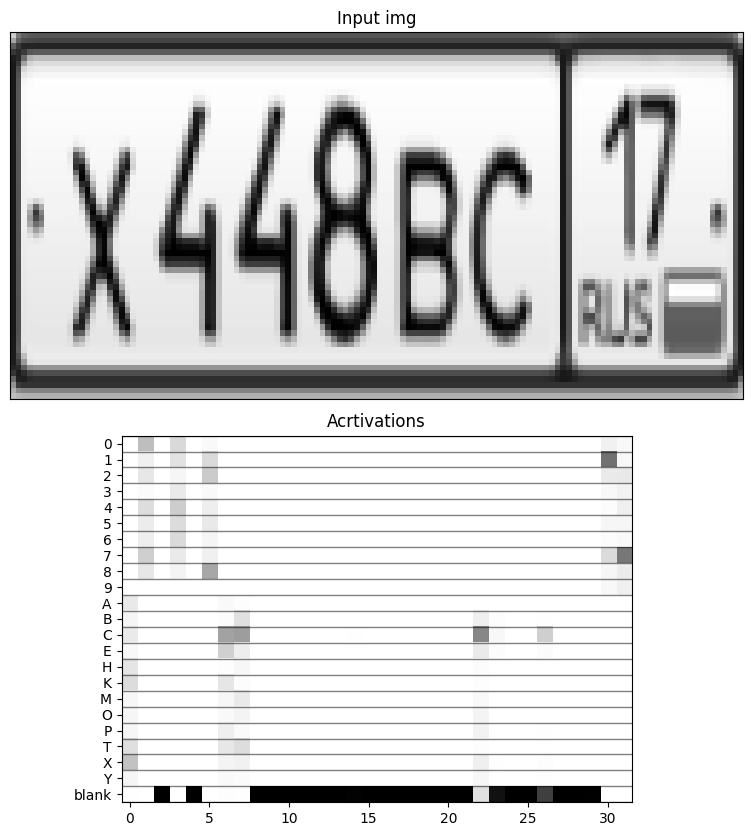

Predicted: K203EX75
Expected: A182EX78


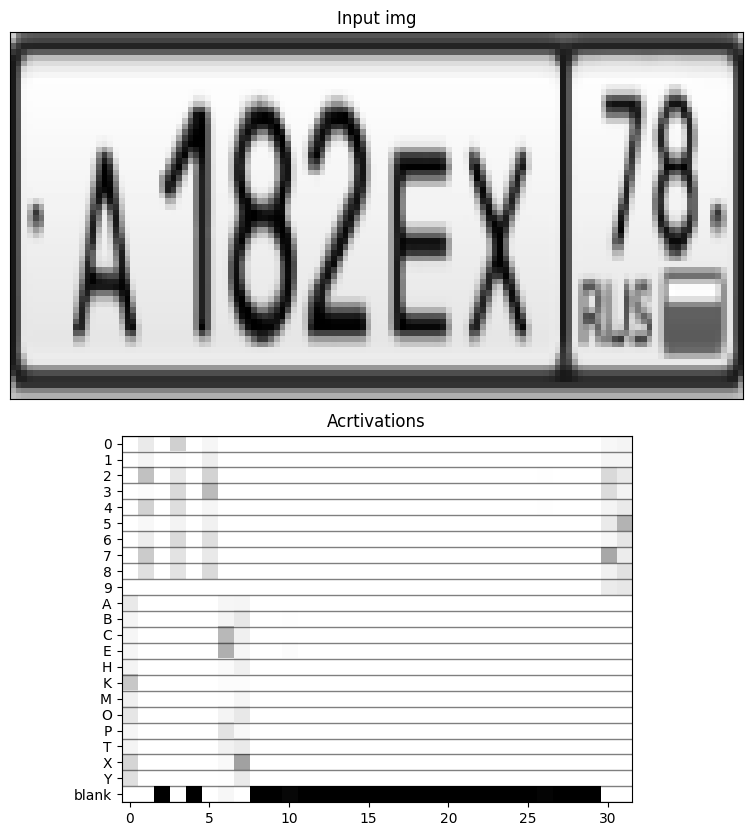

Predicted: H654KE15
Expected: H465HE18


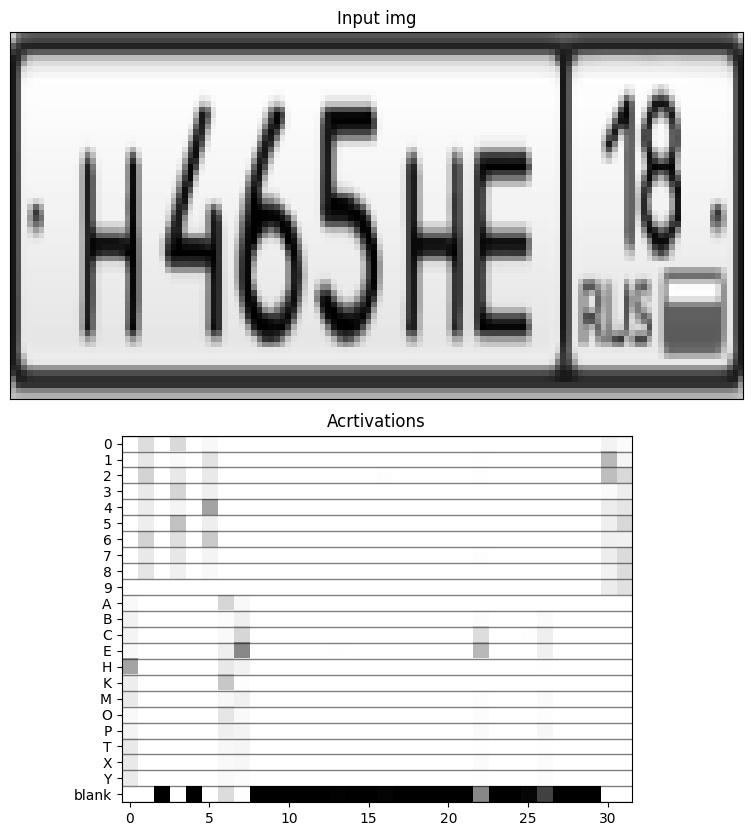

Predicted: T228PT51
Expected: Y853XT81


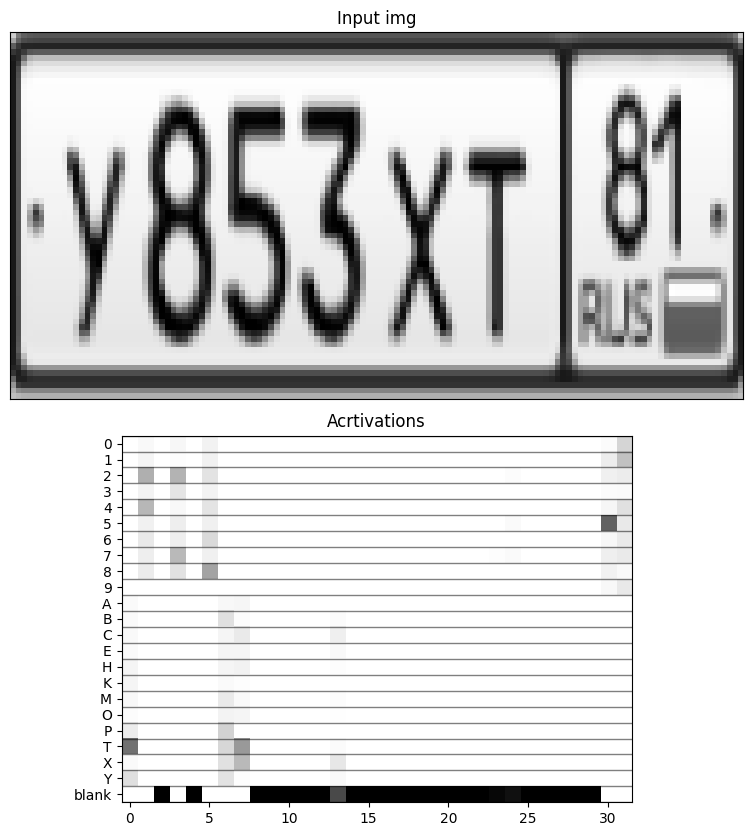

In [74]:
#Визуализация результата

import matplotlib.gridspec as gridspec

TEST_BATCH_SIZE = 4 # меняя батч можно улучшить работу NN

test_data = DataGenerator(TEST_DATA_PATH,
                          img_width=IMG_WIDTH,
                          img_height=IMG_HEIGHT,
                          batch_size=TEST_BATCH_SIZE,
                          letters=LETTERS,
                          max_label_len=PLATE_NUM_LENGTH)

for batch_img, y_true in test_data():
    y_pred = model.predict(batch_img)
    labels_pred = model.decode(y_pred, LETTERS)
    labels = [indices_to_text(i, LETTERS) for i in y_true['labels']]

    for i in range(TEST_BATCH_SIZE):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nExpected: %s' % (labels_pred[i], labels[i]))
        ax1.set_title('Input img')
        ax1.imshow(np.squeeze(batch_img[i]), cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Acrtivations')
        ax2.imshow(y_pred[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(LETTERS) + 1)))
        ax2.set_yticklabels(LETTERS + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(LETTERS) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)

        plt.show()
    break